In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile

In [7]:
# Load the model.
model = hub.load('https://tfhub.dev/google/yamnet/1')

In [9]:
# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names

class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

In [28]:
print(class_names)

['Speech', 'Child speech, kid speaking', 'Conversation', 'Narration, monologue', 'Babbling', 'Speech synthesizer', 'Shout', 'Bellow', 'Whoop', 'Yell', 'Children shouting', 'Screaming', 'Whispering', 'Laughter', 'Baby laughter', 'Giggle', 'Snicker', 'Belly laugh', 'Chuckle, chortle', 'Crying, sobbing', 'Baby cry, infant cry', 'Whimper', 'Wail, moan', 'Sigh', 'Singing', 'Choir', 'Yodeling', 'Chant', 'Mantra', 'Child singing', 'Synthetic singing', 'Rapping', 'Humming', 'Groan', 'Grunt', 'Whistling', 'Breathing', 'Wheeze', 'Snoring', 'Gasp', 'Pant', 'Snort', 'Cough', 'Throat clearing', 'Sneeze', 'Sniff', 'Run', 'Shuffle', 'Walk, footsteps', 'Chewing, mastication', 'Biting', 'Gargling', 'Stomach rumble', 'Burping, eructation', 'Hiccup', 'Fart', 'Hands', 'Finger snapping', 'Clapping', 'Heart sounds, heartbeat', 'Heart murmur', 'Cheering', 'Applause', 'Chatter', 'Crowd', 'Hubbub, speech noise, speech babble', 'Children playing', 'Animal', 'Domestic animals, pets', 'Dog', 'Bark', 'Yip', 'Howl'

In [10]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform
  

In [13]:
import scipy
#wav_file_name = 'speech_whistling2.wav'
#wav_file_name = 'miaow_16k.wav'
wav_file_name = 'm1887_fire1.wav'
sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# Listening to the wav file.
Audio(wav_data, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 1.93s
Size of the input: 30811


In [14]:
waveform = wav_data / tf.int16.max

In [15]:
# Run the model, check the output.
scores, embeddings, spectrogram = model(waveform)

In [16]:
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Explosion


In [43]:
print(infered_class)

Explosion


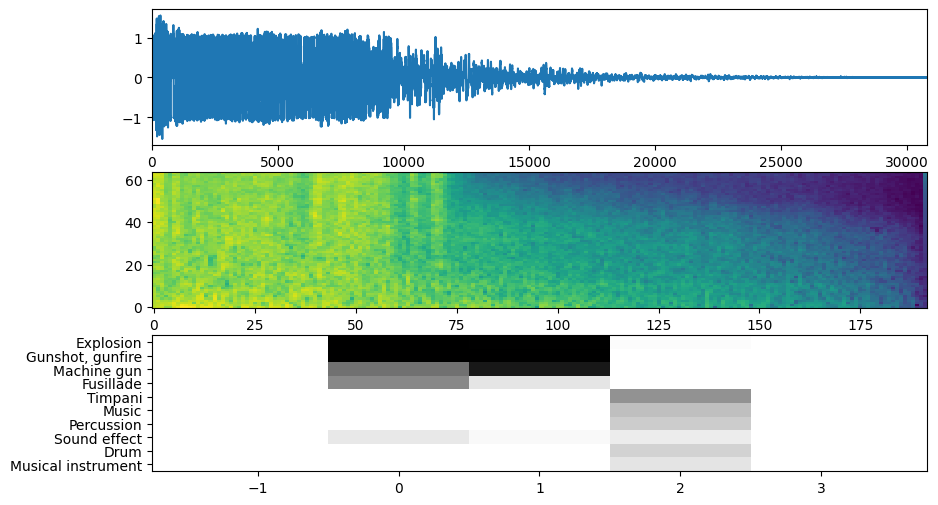

In [17]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))

In [52]:
def classify_sound(clip):
    sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
    sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)
    waveform = wav_data / tf.int16.max
    # Predict scores and classes for the audio clip
    scores, embeddings, spectrogram = model(waveform)
    scores_np = scores.numpy()
    spectrogram_np = spectrogram.numpy()
    infered_class = class_names[scores_np.mean(axis=0).argmax()]
    # Define a threshold
    threshold = tf.reduce_mean(scores_np)
       # Check if the sound is from a known dangerous source
    if infered_class in ['Speech', 'Child speech, kid speaking', 'Conversation', 'Narration, monologue', 'Babbling', 'Speech synthesizer', 'Shout', 'Bellow', 'Whoop', 'Yell', 'Children shouting', 'Screaming', 'Whispering', 'Laughter', 'Baby cry, infant cry', 'Whimper', 'Wail, moan', 'Sigh', 'Singing', 'Choir', 'Yodeling', 'Chant', 'Synthetic singing', 'Rapping', 'Humming', 'Groan', 'Grunt', 'Whistling', 'Snoring', 'Gasp', 'Pant', 'Snort', 'Cough', 'Sneeze', 'Sniff', 'Run', 'Shuffle', 'Walk, footsteps',  'Biting', 'Gargling','Burping, eructation', 'Hiccup', 'Fart', 'Hands', 'Finger snapping', 'Clapping', 'Heart sounds, heartbeat', 'Heart murmur',  'Chatter', 'Crowd', 'Hubbub, speech noise, speech babble',  'Dog', 'Bark',  'Whimper (dog)', 'Horse',  'Canidae, dogs, wolves',  'Whale vocalization', 'Music', 'Musical instrument', 'Plucked string instrument', 'Guitar', 'Electric guitar', 'Bass guitar', 'Acoustic guitar', 'Steel guitar, slide guitar', 'Tapping (guitar technique)', 'Strum', 'Banjo', 'Sitar', 'Mandolin', 'Zither', 'Ukulele', 'Keyboard (musical)', 'Piano', 'Electric piano', 'Organ', 'Electronic organ', 'Hammond organ', 'Synthesizer', 'Sampler', 'Harpsichord', 'Percussion', 'Drum kit', 'Drum machine', 'Drum', 'Snare drum', 'Rimshot', 'Drum roll', 'Bass drum', 'Timpani', 'Tabla', 'Cymbal', 'Hi-hat', 'Wood block', 'Tambourine', 'Rattle (instrument)', 'Maraca', 'Gong', 'Tubular bells', 'Mallet percussion', 'Marimba, xylophone', 'Glockenspiel', 'Vibraphone', 'Steelpan', 'Orchestra', 'Brass instrument', 'French horn', 'Trumpet', 'Trombone', 'Bowed string instrument', 'String section', 'Violin, fiddle', 'Pizzicato', 'Cello', 'Double bass', 'Wind instrument, woodwind instrument', 'Flute', 'Saxophone', 'Clarinet', 'Harp', 'Bell', 'Church bell', 'Jingle bell', 'Bicycle bell', 'Tuning fork', 'Chime', 'Wind chime', 'Change ringing (campanology)', 'Harmonica', 'Accordion', 'Bagpipes', 'Didgeridoo', 'Shofar', 'Theremin', 'Singing bowl', 'Scratching (performance technique)', 'Pop music', 'Hip hop music', 'Beatboxing', 'Rock music', 'Heavy metal', 'Punk rock', 'Grunge', 'Progressive rock', 'Rock and roll', 'Psychedelic rock', 'Rhythm and blues', 'Soul music', 'Reggae', 'Country', 'Swing music', 'Bluegrass', 'Funk', 'Folk music', 'Middle Eastern music', 'Jazz', 'Disco', 'Classical music', 'Opera', 'Electronic music', 'House music', 'Techno', 'Dubstep', 'Drum and bass', 'Electronica', 'Electronic dance music', 'Ambient music', 'Trance music', 'Music of Latin America', 'Salsa music', 'Flamenco', 'Blues', 'Music for children', 'New-age music', 'Vocal music', 'A capella', 'Music of Africa', 'Afrobeat', 'Christian music', 'Gospel music', 'Music of Asia', 'Carnatic music', 'Music of Bollywood', 'Ska', 'Traditional music', 'Independent music', 'Song', 'Background music', 'Theme music', 'Jingle (music)', 'Soundtrack music', 'Lullaby', 'Video game music', 'Christmas music', 'Dance music', 'Wedding music', 'Happy music', 'Sad music', 'Tender music', 'Exciting music', 'Angry music', 'Gurgling', 'Fire', 'Crackle', 'Vehicle','Motorboat, speedboat', 'Motor vehicle (road)', 'Car', 'Vehicle horn, car horn, honking', 'Toot', 'Car alarm', 'Power windows, electric windows', 'Skidding', 'Tire squeal', 'Car passing by', 'Race car, auto racing', 'Truck', 'Air brake', 'Air horn, truck horn', 'Reversing beeps', 'Ice cream truck, ice cream van', 'Bus', 'Emergency vehicle', 'Police car (siren)', 'Ambulance (siren)', 'Fire engine, fire truck (siren)', 'Motorcycle', 'Traffic noise, roadway noise', 'Train whistle',  'Aircraft', 'Aircraft engine', 'Jet engine', 'Propeller, airscrew', 'Helicopter', 'Fixed-wing aircraft, airplane', 'Bicycle', 'Engine', 'Light engine (high frequency)', 'Medium engine (mid frequency)', 'Heavy engine (low frequency)', 'Engine knocking', 'Engine starting', 'Idling', 'Accelerating, revving, vroom', 'Typing', 'Typewriter', 'Computer keyboard', 'Writing', 'Alarm', 'Telephone', 'Telephone bell ringing', 'Ringtone', 'Telephone dialing, DTMF', 'Dial tone', 'Busy signal', 'Alarm clock',  'Fire alarm', 'Foghorn', 'Whistle', 'Steam whistle', 'Mechanisms','Cash register', 'Camera', 'Single-lens reflex camera', 'Tools', 'Hammer', 'Jackhammer', 'Sawing', 'Filing (rasp)', 'Sanding', 'Power tool', 'Drill', 'Explosion', 'Gunshot, gunfire', 'Machine gun', 'Fusillade', 'Artillery fire', 'Cap gun', 'Fireworks', 'Firecracker', 'Burst, pop', 'Eruption', 'Boom', 'Gush', 'Smash, crash', 'Crushing' , 'Beep, bleep','Hum', 'Outside, urban or manmade', 'Radio']:
        return "dangerous"

    # Check if the sound is from a known benign source
    if "bird, cricket" in infered_class:
        return "benign"


In [53]:
classify_sound(wav_file_name)

'dangerous'